# Тестовое задание Авито

## Курманаева Эвелина

### Датасет

Датасет, на котором обучалась модель, взят по этой ссылке: https://www.kaggle.com/datasets/vitaliy3000/avito-dataset?select=train.csv

Использовался данный датасет, так как он похож по стилю, формулировкам и структуре предложений с датасетом `dataset_1937770_3.txt` . Его легко собрать, достаточно создать колонку `input`, просто удалив пробелы в правильном тексте.

### Основная идея

На вход модели подается текст без пробелов, и она классифицирует каждый токен как `0` (не вставлять пробел) или `1` (ставить пробел после токена), то есть выполняется задача последовательной бинарной классификации (sequence labeling). После этого с помощью функции `restore_spaces` восстанавливается текст с пробелами на местах, где модель предсказала `1`.

### Токенизация

Токенизация выполняется с помощью **Byte-Pair Encoding (BPE)**, который разбивает текст на подслова, а не на отдельные символы. Это позволяет сократить длину последовательности, ускорить обучение, экономить память и сохранить морфологическую информацию. В отличие от посимвольного токенизатора, BPE учитывает статистику сочетаний символов, что помогает модели лучше понимать морфологию слов и их границы. Этот вывод был сделан при сравнении BPE и char-encoding.

Так как изначальная маска посимвольная, то она не подходит при использовании BPE. Поэтому с помощью функции `make_labels` формируются **новые маски**. Для каждого текста каждому токену присваивается метка из исходной маски. С помощью `offset_mapping` узнаём, какие символы входят в токен, и берём значение из маски для последнего символа токена (`0` — пробел не ставить, `1` — ставить).

### Модель

В работе используется [**модель XLM-RoBERTa**](https://huggingface.co/FacebookAI/xlm-roberta-base) — улучшенная версия BERT, обученная на большом многоязычном корпусе. Она обрабатывает последовательность токенов и учитывает связи между ними в обе стороны. Благодаря механизму self-attention модель может выделять наиболее значимые токены в контексте всей фразы и улавливать синтаксические закономерности.

### Почему этот метод решения лучше эвристики

Было решено, что для задачи восстановления пробелов **эвристика плохо работает**, потому что входные данные — не всегда чистый текст: пользователь может опечататься, писать в разном стиле (полностью заглавными буквами, чередуя заглавные с прописными и т.д.). Эвристики с помощью словаря не могут учесть все варианты, потому что список слов не может быть полным. Кроме того, решение о том, нужен ли пробел, зависит от смысла, а не только от формы слова.

### Проблема дисбаланса классов

При решении задачи наблюдается сильный **дисбаланс классов**: меток `0` больше, чем меток `1`. Если обучать модель без учета этого дисбаланса, она будет склоняться к тому, чтобы всегда предсказывать `0`, что приведет к низкому качеству восстановления текста. Чтобы компенсировать дисбаланс, я использовала взвешенную функцию потерь: веса для каждого класса вычислялись как обратные их частотам.

### Обучение модели

Для обучения модели используется **пакетная обработка данных**, при которой длины последовательностей внутри батча выравниваются с помощью функции `collate_fn`. Для каждой выборки определяется максимальная длина последовательности, и все остальные последовательности дополняются до этой длины. `labels` выравниваются значением `-100`, чтобы паддинги не влияли на обучение при вычислении функции потерь.

### Мощности для обучения

Обучение и инференс выполнялись на **MacBook M1 Pro с поддержкой MPS**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.optim import AdamW
from sklearn.metrics import f1_score

device = (
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

device

'mps'

# Обработка датасета

In [ ]:
data = pd.read_csv("train.csv")[["title"]]

data

,title
0,Картина
1,Стулья из прессованной кожи
2,Домашняя мини баня
3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок"
4,Ноутбук aser
...,...
489512,Music MAN JP6 piezo
489513,Резолюции и постановления пленумов цк вкпб 1933г
489514,Дверь входная металлическая Китайская
489515,Чехол на samsung S6 duos


In [ ]:
data = data.drop_duplicates()

In [ ]:
data.shape

(365152, 1)

In [ ]:
data["input"] = data["title"].str.replace(" ", "")

In [ ]:
data.columns = ["output", "input"]
data.head()

,output,input
0,Картина,Картина
1,Стулья из прессованной кожи,Стульяизпрессованнойкожи
2,Домашняя мини баня,Домашняяминибаня
3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Эксклюзивнаяколлекциякниг""Трансаэро""+подарок"
4,Ноутбук aser,Ноутбукaser


### Создание целевой переменной

Создадим маску, в которой 0 - это символ (буква/цифра/и т.д.), а 1 - значит нужно вставить пробел после текущего символа

In [ ]:
def make_mask(text):
    mask = []
    for i, char in enumerate(text):
        if char == " ":
            continue
        if i + 1 < len(text) and text[i + 1] == " ":
            mask.append(1)
        else:
            mask.append(0)

    return mask

In [ ]:
data["mask"] = data["output"].apply(make_mask)

In [ ]:
data

,output,input,mask
0,Картина,Картина,"[0, 0, 0, 0, 0, 0, 0]"
1,Стулья из прессованной кожи,Стульяизпрессованнойкожи,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,Домашняя мини баня,Домашняяминибаня,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]"
3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Эксклюзивнаяколлекциякниг""Трансаэро""+подарок","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,Ноутбук aser,Ноутбукaser,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
...,...,...,...
489512,Music MAN JP6 piezo,MusicMANJP6piezo,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
489513,Резолюции и постановления пленумов цк вкпб 1933г,Резолюцииипостановленияпленумовцквкпб1933г,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
489514,Дверь входная металлическая Китайская,ДверьвходнаяметаллическаяКитайская,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
489515,Чехол на samsung S6 duos,ЧехолнаsamsungS6duos,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."


### Разделение на train/test

In [ ]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, shuffle=True
)

# Токенизация

Загружаем предобученные токенизатор RoBERTa.

In [ ]:
model_name = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=2)

model.to(device);

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Создаем labels, соответствующие размеру токенизированных предложений

In [ ]:
def make_labels(text, mask):
    encoding = tokenizer(text, add_special_tokens=False, return_offsets_mapping=True)

    token_labels = []
    for start, end in encoding.offset_mapping:
        if end - 1 < len(mask):
            token_labels.append(mask[end - 1])
        else:
            token_labels.append(0)

    encoding["labels"] = token_labels
    return encoding

In [ ]:
class SpaceDatasetBPE(Dataset):
    def __init__(self, texts, masks):
        self.encodings = [make_labels(t, m) for t, m in zip(texts, masks)]

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val)
            for key, val in self.encodings[idx].items()
            if key in ["input_ids", "attention_mask", "labels"]
        }
        return item

In [ ]:
def collate_fn(batch):
    max_len = max([item["input_ids"].size(0) for item in batch])

    input_ids = []
    attention_mask = []
    labels = []

    for item in batch:
        seq_len = item["input_ids"].size(0)

        padded_input_ids = torch.cat(
            [item["input_ids"], torch.zeros(max_len - seq_len, dtype=torch.long)]
        )
        input_ids.append(padded_input_ids)

        padded_attention_mask = torch.cat(
            [item["attention_mask"], torch.zeros(max_len - seq_len, dtype=torch.long)]
        )
        attention_mask.append(padded_attention_mask)

        padded_labels = torch.cat(
            [item["labels"], torch.full((max_len - seq_len,), -100, dtype=torch.long)]
        )
        labels.append(padded_labels)

    return {
        "input_ids": torch.stack(input_ids),
        "attention_mask": torch.stack(attention_mask),
        "labels": torch.stack(labels),
    }


Формируем тренировычный и тестовый dataloader. В качестве оптимизатора градиентного спуска берем AdamW

In [ ]:
train_dataset = SpaceDatasetBPE(
    train_data["input"].tolist(), train_data["mask"].tolist()
)

test_dataset = SpaceDatasetBPE(test_data["input"].tolist(), test_data["mask"].tolist())


train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn
)

Так как в данных присутствует дисбаланс, задаём веса для классов в CrossEntropyLoss, чтобы ошибки на редком классе оказывали больший вклад в функцию потерь

In [ ]:
all_masks = []

for lst in train_data["mask"].tolist():
    all_masks.extend(lst)

In [ ]:
num_0 = all_masks.count(0)
num_1 = all_masks.count(1)

weight_0 = num_1 / len(all_masks)
weight_1 = num_0 / len(all_masks)

weights = torch.tensor([weight_0, weight_1], dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = AdamW(model.parameters(), lr=5e-5)

### Обучение модели

In [ ]:
train_losses = []

In [ ]:
epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in (bar := tqdm(train_loader)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits.view(-1, 2), labels.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

        train_losses.append(loss.item())
        bar.set_description(
            f"Loss: {sum(train_losses[-10:]) / len(train_losses[-10:]):.5f}"
        )

    train_loss_epoch = total_loss / len(train_loader)

    model.eval()
    test_loss = 0.0
    all_preds_test = []
    all_labels_test = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids, attention_mask=batch["attention_mask"].to(device)
            )
            logits = outputs.logits

            loss = criterion(logits.view(-1, 2), labels.view(-1))
            test_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            all_preds_test.extend(preds.view(-1).cpu().numpy())
            all_labels_test.extend(labels.view(-1).cpu().numpy())

    test_loss_epoch = test_loss / len(test_loader)

    print(
        f"Epoch {epoch + 1} | Train Loss: {train_loss_epoch:.4f} |  Test Loss: {test_loss_epoch:.4f}"
    )


Loss: 0.04950: 100%|██████████| 2283/2283 [25:19<00:00,  1.50it/s]


Epoch 1 | Train Loss: 0.0525 |  Test Loss: 0.0616


Loss: 0.05209: 100%|██████████| 2283/2283 [25:11<00:00,  1.51it/s]


Epoch 2 | Train Loss: 0.0482 |  Test Loss: 0.0599


В итоге, модель обучалась на 5 эпохах:

Loss: 0.07847: 100%|██████████| 2283/2283 [25:14<00:00,  1.51it/s]

Epoch 1 | Train Loss: 0.1013 |  Test Loss: 0.0674

Loss: 0.05652: 100%|██████████| 2283/2283 [25:15<00:00,  1.51it/s]

Epoch 2 | Train Loss: 0.0662 |  Test Loss: 0.0609

Loss: 0.05259: 100%|██████████| 2283/2283 [25:11<00:00,  1.51it/s]

Epoch 3 | Train Loss: 0.0583 |  Test Loss: 0.0615

Loss: 0.04950: 100%|██████████| 2283/2283 [25:19<00:00,  1.50it/s]

Epoch 4 | Train Loss: 0.0525 |  Test Loss: 0.0616

Loss: 0.05209: 100%|██████████| 2283/2283 [25:11<00:00,  1.51it/s]

Epoch 5 | Train Loss: 0.0482 |  Test Loss: 0.0599

In [ ]:
learning_process = pd.DataFrame(
    {
        "train_losses": train_losses,
    }
)

learning_process.to_csv("learning_process.csv", index=False)

In [ ]:
torch.save(model.state_dict(), "AVITO_space_model.pth")

График обучения:

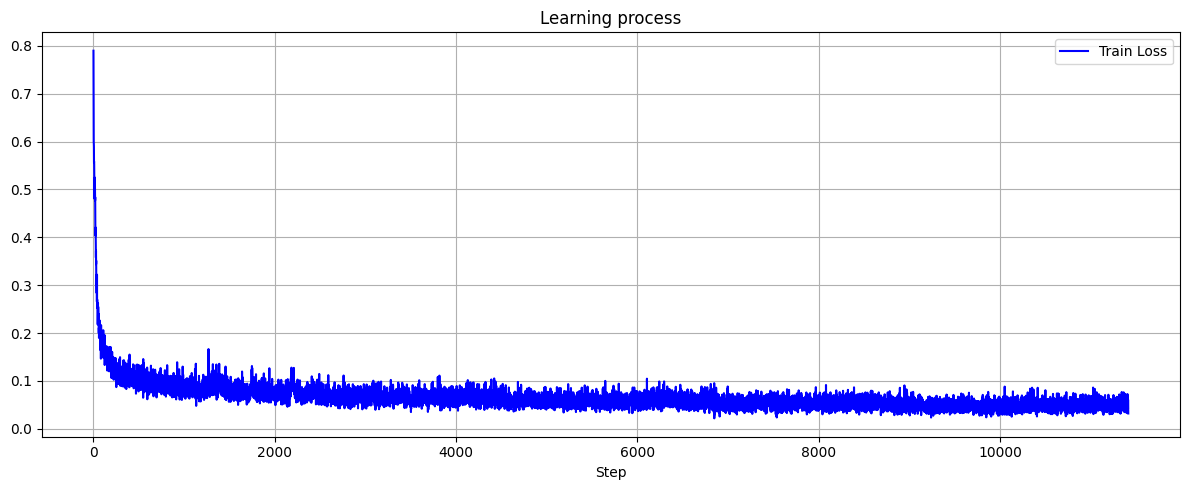

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(train_losses, label="Train Loss", color="blue")

plt.title("Learning process")
plt.xlabel("Step")

plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

### Оценка качества модели

In [ ]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids, attention_mask=batch["attention_mask"].to(device)
        )
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        valid_mask = labels != -100

        preds.extend(predictions[valid_mask].cpu().numpy().flatten())
        trues.extend(labels[valid_mask].cpu().numpy().flatten())

f1 = f1_score(trues, preds)
print(f"Test F1: {f1:.4f}")


100%|██████████| 571/571 [01:31<00:00,  6.24it/s]


Test F1: 0.9502


Функция для вставки пробелов в исходный текст:

In [ ]:
def restore_spaces(text):
    encoding = tokenizer(
        text, return_tensors="pt", add_special_tokens=False, return_offsets_mapping=True
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        preds = logits.argmax(dim=-1).squeeze().cpu().tolist()

    restored = ""
    for id, p, (start, end) in zip(
        input_ids.squeeze().cpu().tolist(), preds, encoding.offset_mapping[0]
    ):
        tok = tokenizer.decode([id])
        restored += tok
        if p == 1:
            restored += " "
    return restored


example = "этопроверкакакбудетработатьмодель"
print("INPUT:", example)
print("OUTPUT:", restore_spaces(example))

INPUT: этопроверкакакбудетработатьмодель
OUTPUT: это проверка как будет работать модель


In [ ]:
example = "ищусобакунемецкуюовчарку"
print("INPUT:", example)
print("OUTPUT:", restore_spaces(example))

INPUT: ищусобакунемецкуюовчарку
OUTPUT: ищу собаку немецкую овчарку


### Результат на датасете авито

In [ ]:
file_path = "dataset_1937770_3.txt"

data = []

with open(file_path, "r", encoding="utf-8") as f:
    header = next(f)
    for line in f:
        line = line.strip()
        if not line:
            continue
        id_part, text_part = line.split(",", 1)
        data.append((int(id_part), text_part))


avito_data = pd.DataFrame(data, columns=["id", "text"])


In [ ]:
avito_data

,id,text
0,0,куплюайфон14про
1,1,ищудомвПодмосковье
2,2,сдаюквартирусмебельюитехникой
3,3,новыйдивандоставканедорого
4,4,отдамдаромкошку
...,...,...
1000,1000,Янеусну.
1001,1001,Весна-яуженегреюпио.
1002,1002,Весна-скоровырастеттрава.
1003,1003,"Весна-выпосмотрите,каккрасиво."


In [ ]:
avito_data["result"] = avito_data["text"].apply(restore_spaces)

In [ ]:
avito_data

,id,text,result
0,0,куплюайфон14про,куплю айфон 14 про
1,1,ищудомвПодмосковье,ищу дом в Подмосковье
2,2,сдаюквартирусмебельюитехникой,сдаю квартиру смебелью и техникой
3,3,новыйдивандоставканедорого,новый диван доставка не дорого
4,4,отдамдаромкошку,отдам даром кошку
...,...,...,...
1000,1000,Янеусну.,Я не у сну.
1001,1001,Весна-яуженегреюпио.,Весна - я ужене грею пио.
1002,1002,Весна-скоровырастеттрава.,Весна - скоро вырастет трава.
1003,1003,"Весна-выпосмотрите,каккрасиво.","Весна - вы посмотрите, как красиво."


In [ ]:
avito_data[:20]

,id,text,result
0,0,куплюайфон14про,куплю айфон 14 про
1,1,ищудомвПодмосковье,ищу дом в Подмосковье
2,2,сдаюквартирусмебельюитехникой,сдаю квартиру смебелью и техникой
3,3,новыйдивандоставканедорого,новый диван доставка не дорого
4,4,отдамдаромкошку,отдам даром кошку
5,5,работавМосквеудаленно,работа в Москве удаленно
6,6,куплютелевизорPhilips,куплю телевизор Philips
7,7,ищугрузчиковдляпереезда,ищу грузчиков для переезда
8,8,ремонтквартирподключ,ремонт квартир под ключ
9,9,куплюноутбукHP,куплю ноутбук HP


Функция для получения индекса, куда вставить пробел

In [ ]:
def get_index_space(text):
    i = 0
    indexes = []
    while i < len(text):
        if text[i] == " ":
            indexes.append(i - len(indexes))
            i += 1
        i += 1

    return indexes


In [ ]:
avito_data["predicted_positions"] = avito_data.result.apply(get_index_space)

In [ ]:
avito_data

,id,text,result,predicted_positions
0,0,куплюайфон14про,куплю айфон 14 про,"[5, 10, 12]"
1,1,ищудомвПодмосковье,ищу дом в Подмосковье,"[3, 6, 7]"
2,2,сдаюквартирусмебельюитехникой,сдаю квартиру смебелью и техникой,"[4, 12, 20, 21]"
3,3,новыйдивандоставканедорого,новый диван доставка не дорого,"[5, 10, 18, 20]"
4,4,отдамдаромкошку,отдам даром кошку,"[5, 10]"
...,...,...,...,...
1000,1000,Янеусну.,Я не у сну.,"[1, 3, 4]"
1001,1001,Весна-яуженегреюпио.,Весна - я ужене грею пио.,"[5, 6, 7, 12, 16]"
1002,1002,Весна-скоровырастеттрава.,Весна - скоро вырастет трава.,"[5, 6, 11, 19]"
1003,1003,"Весна-выпосмотрите,каккрасиво.","Весна - вы посмотрите, как красиво.","[5, 6, 8, 19, 22]"


# Формирование submission файла


In [ ]:
submission = avito_data[["id", "predicted_positions"]]
submission.to_csv("submission.csv", index=False)

In [ ]:
df = pd.read_csv("submission.csv")
df

,id,predicted_positions
0,0,"[5, 10, 12]"
1,1,"[3, 6, 7]"
2,2,"[4, 12, 20, 21]"
3,3,"[5, 10, 18]"
4,4,"[5, 10]"
...,...,...
1000,1000,"[1, 3, 4, 8]"
1001,1001,"[7, 12, 16]"
1002,1002,"[5, 6, 11, 19, 25]"
1003,1003,"[5, 6, 8, 19, 22]"
